# Model Testing Notebook: MPEG-7 Dataset & Pre-Trained Model

**Objective:**  
Load the pre-generated datasets and the pre-trained NumerosityCNN model, evaluate its performance on the test set, and visualize the results.

- Set reproducibility seed and import libraries.
- Load the saved datasets.
- Load the pre-trained model.
- Evaluate the model on the test set (loss, accuracy, confusion matrix, and classification report).
- Visualize sample predictions.

**Note:**  
Make sure that the files **`train_dataset.pt`,** **`val_dataset.pt`**, **`test_dataset.pt`** and **`final_numerosity_model.pt`** are in your working directory.



# Environment Setup and Seed Setting

In [1]:
import random
import numpy as np
import torch
import os
import tarfile
import urllib.request
import cv2
import glob
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


# MPEG7 Dataset Generation

In [2]:
!apt-get install -y libglib2.0-0 libsm6 libxrender1 libxext6
!pip install opencv-python matplotlib -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsm6 is already the newest version (2:1.2.3-1build2).
libxext6 is already the newest version (2:1.3.4-1build1).
libxrender1 is already the newest version (1:0.9.10-1build4).
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.4).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Download & Extract MPEG-7 Shape Dataset

In [5]:
DATASET_URL = "https://dabi.temple.edu/external/shape/MPEG7/MPEG7dataset.zip"
ZIP_PATH = "./mpeg7.zip"
EXTRACT_DIR = "./mpeg7"
SILHOUETTE_DIR = os.path.join(EXTRACT_DIR, "original")

In [6]:
if not os.path.exists(SILHOUETTE_DIR):
    print("Downloading MPEG-7 Dataset...")
    urllib.request.urlretrieve(DATASET_URL, ZIP_PATH)

    print("Extracting...")
    import zipfile
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("Download and extraction complete.")
else:
    print("Dataset already exists.")

Extracting...
Download and extraction complete.


# Visualize Sample Silhouettes

In [7]:
!pip install imageio -q

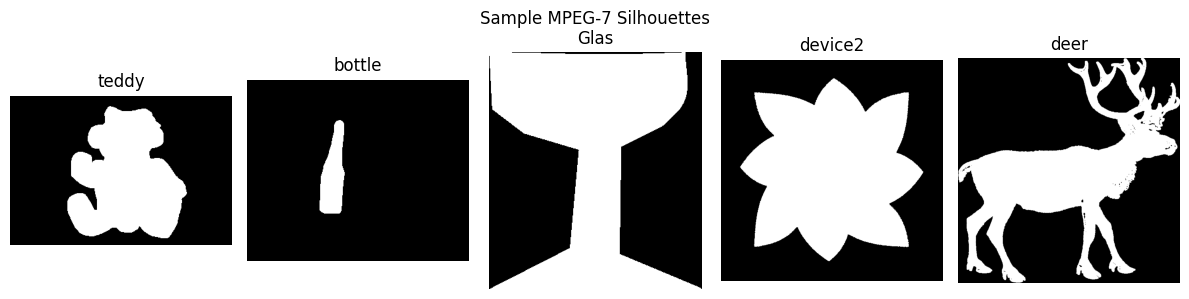

In [8]:
import imageio.v3 as iio

all_gifs = sorted(glob.glob(os.path.join(SILHOUETTE_DIR, "*.gif")))
plt.figure(figsize=(12, 3))
for i, path in enumerate(random.sample(all_gifs, 5)):
    img = iio.imread(path)[0]  # Select the first frame-
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(path).split("-")[0])
    plt.axis("off")
plt.suptitle("Sample MPEG-7 Silhouettes")
plt.tight_layout()
plt.show()

# Generate Numerosity Images from Silhouettes

In [9]:
OUTPUT_DIR = "./numerosity_mpeg7"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LABELS = {0: "Few", 1: "Medium", 2: "Many"}
CATEGORY_THRESHOLDS = [5, 15]  # Few: 1-5, Medium: 6-15, Many: 16-30
IMAGE_SIZE = 128
NUM_IMAGES = 3000

In [10]:
import glob
import imageio.v3 as iio

print("Loading silhouette images...")
silhouette_images = []
img_paths = glob.glob(os.path.join(SILHOUETTE_DIR, '*.gif'))
for path in img_paths:
    try:
        img = iio.imread(path)[0]
        if img is not None:
            silhouette_images.append(img)
    except Exception as e:
        print(f"Failed to read {path}: {e}")

print(f"Loaded {len(silhouette_images)} silhouettes.")

Loading silhouette images...
Loaded 1402 silhouettes.


In [11]:
# Categorize numerosity
def categorize(count):
    if count <= CATEGORY_THRESHOLDS[0]: return 0
    elif count <= CATEGORY_THRESHOLDS[1]: return 1
    else: return 2

# Composite image generator
def generate_composite():
    canvas = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
    num_shapes = random.randint(1, 30)

    shape = random.choice(silhouette_images)
    if len(shape.shape) > 2:
        shape = cv2.cvtColor(shape, cv2.COLOR_BGR2GRAY)

    shape = cv2.resize(shape, (random.randint(20, 40), random.randint(20, 40)))
    h, w = shape.shape

    for _ in range(num_shapes):
        x = random.randint(0, IMAGE_SIZE - w)
        y = random.randint(0, IMAGE_SIZE - h)
        roi = canvas[y:y+h, x:x+w]
        canvas[y:y+h, x:x+w] = np.maximum(roi, (shape > 127).astype(np.uint8) * 255)

    return canvas, categorize(num_shapes)
# Generate and save images
print("Generating dataset...")
for i in tqdm(range(NUM_IMAGES)):
    img, label = generate_composite()
    save_path = os.path.join(OUTPUT_DIR, f"img_{i:04d}_label_{label}.png")
    cv2.imwrite(save_path, img)
print("Numerosity dataset generation complete!")

Generating dataset...


100%|██████████| 3000/3000 [00:01<00:00, 2506.14it/s]

Numerosity dataset generation complete!


# Visualize samples

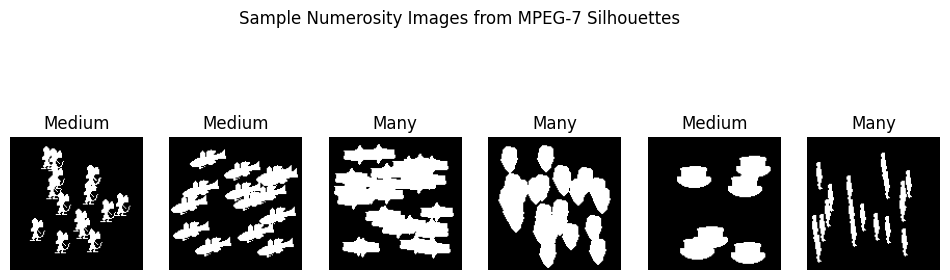

In [12]:
samples = random.sample(glob.glob(os.path.join(OUTPUT_DIR, '*.png')), 6)
plt.figure(figsize=(12, 4))
for i, path in enumerate(samples):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = LABELS[int(path.split('_')[-1].split('.')[0])]
    plt.subplot(1, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Numerosity Images from MPEG-7 Silhouettes")
plt.show()

# Prepare Dataset for Model

In [13]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
import os

# Step 1: Define a custom dataset
class NumerositySilhouetteDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("L")
        label = int(path.split("_")[-1].split(".")[0])
        if self.transform:
            img = self.transform(img)
        return img, label

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to [C x H x W], with range [0,1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize grayscale to [-1, 1]
])

In [15]:
dataset = NumerositySilhouetteDataset(OUTPUT_DIR, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [16]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(val_dataset, "val_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

print(f"Saved: {len(train_dataset)} train / {len(val_dataset)} val / {len(test_dataset)} test")

Saved: 2100 train / 450 val / 450 test


# Define the Model Architecture

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class NumerosityCNN(nn.Module):
    def __init__(self):
        super(NumerosityCNN, self).__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        # Input size 128x128 becomes 16x16 after 3 rounds of 2x2 pooling.
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, 3)  # Three classes: Few, Medium, Many

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out)

# Load the Pre-Trained Model

### Load the pre-trained model from the saved checkpoint "final_numerosity_model.pt".

In [18]:
model = NumerosityCNN().to(device)
model.load_state_dict(torch.load("final_numerosity_model.pt", map_location=device))
model.eval()
print("Pre-trained model loaded successfully.")

Pre-trained model loaded successfully.


# Evaluate the Model on the Test Set

### Compute test loss, test accuracy and generate confusion matrix and classification report.

In [19]:
from PIL import Image

In [20]:
import warnings
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

from torch.utils.data.dataset import Subset
import torch.serialization

torch.serialization.add_safe_globals([Subset])

# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt", weights_only=False)
val_dataset = torch.load("val_dataset.pt", weights_only=False)
test_dataset = torch.load("test_dataset.pt", weights_only=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # default value; can be tuned later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Size: 2100
Validation Dataset Size: 450
Test Dataset Size: 450


In [21]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    return avg_loss, accuracy, all_labels, all_preds

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 93.1444, Test Accuracy: 15.78%


# Confusion Matrix

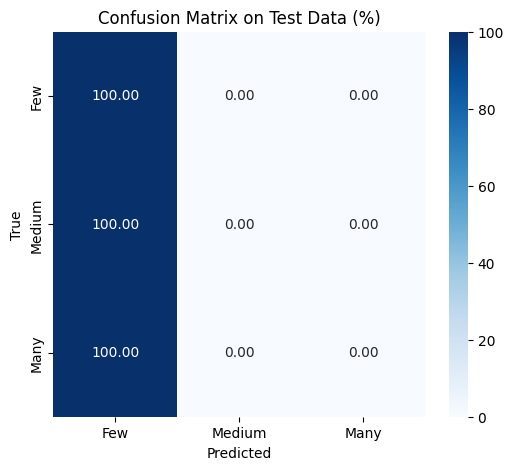

Classification Report:
              precision    recall  f1-score   support

         Few       0.16      1.00      0.27        71
      Medium       0.00      0.00      0.00       156
        Many       0.00      0.00      0.00       223

    accuracy                           0.16       450
   macro avg       0.05      0.33      0.09       450
weighted avg       0.02      0.16      0.04       450



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
cm = confusion_matrix(test_labels, test_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Few", "Medium", "Many"],
            yticklabels=["Few", "Medium", "Many"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data (%)")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Few", "Medium", "Many"]))

# Visualize Test Images with Predictions

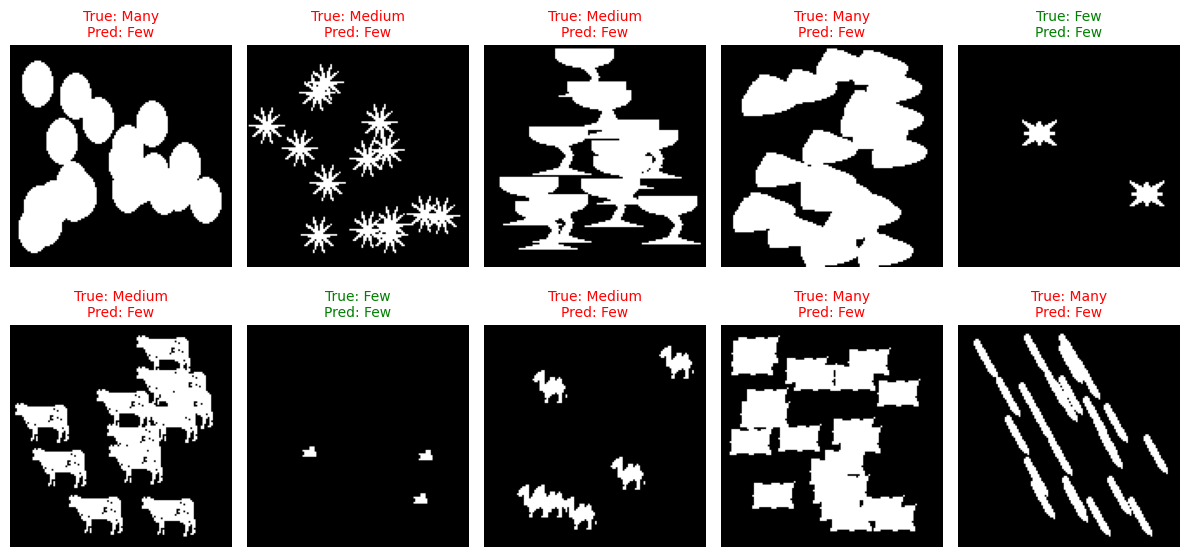

In [23]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Map numeric labels to class names
label_names = {0: "Few", 1: "Medium", 2: "Many"}

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):  # Show 10 sample test images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    true_label = label_names[labels[i].item()]
    pred_label = label_names[predicted[i].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Save Experiment Results

In [24]:
results_dict = {
    "test_loss": [test_loss,],
    "test_accuracy": [test_accuracy]
}
pd.DataFrame(results_dict).to_csv("test_results_run.csv", index=False)
print("Test results saved as 'test_results_run.csv'.")

Test results saved as 'test_results_run.csv'.
